In [18]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import ImageDraw, Image
import torch.nn as nn
import torch.optim as optim
import cv2
import matplotlib.pyplot as plt

class SyntheticDataset(Dataset):
    def __init__(self, num_samples, image_size=(128, 128)):
        self.num_samples = num_samples
        self.image_size = image_size

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        image = self.generate_image()
        mask = self.generate_mask(image)
        image = transforms.ToTensor()(image)
        mask = transforms.ToTensor()(mask)
        return image, mask

    def generate_image(self):
        image = Image.new("RGB", self.image_size, color="white")
        draw = ImageDraw.Draw(image)

        num_shapes = np.random.randint(1, 4) # random generate
        for _ in range(num_shapes):
            shape = np.random.choice(['rectangle', 'circle'])
            color = tuple(np.random.randint(0, 255, size=3))

            if shape == 'rectangle':
                pt1 = tuple(np.random.randint(0, self.image_size[0] // 2, size=2))
                pt2 = tuple(np.random.randint(self.image_size[0] // 2, self.image_size[0], size=2))
                draw.rectangle([pt1, pt2], fill=color)
            elif shape == 'circle':
                center = tuple(np.random.randint(0, self.image_size[0], size=2))
                radius = np.random.randint(10, self.image_size[0] // 4)
                draw.ellipse([center[0] - radius, center[1] - radius, center[0] + radius, center[1] + radius], fill=color)

        return image

    def generate_mask(self, image):
        image_gray = np.array(image.convert('L')) # greyscale conversion

        _, mask = cv2.threshold(image_gray, 127, 255, cv2.THRESH_BINARY) # masking

        return Image.fromarray(mask)

#Ex:
synthetic_dataset = SyntheticDataset(num_samples=100)
train_loader = DataLoader(synthetic_dataset, batch_size=16, shuffle=True)


In [19]:
class SimpleCNN(nn.Module):
    def __init__(self):   # Convo Net def
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 1, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x): # foward propogation
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        x = self.sigmoid(x)
        return x
#Model
model = SimpleCNN()


In [20]:
criterion = nn.BCELoss()   # loss Func
optimizer = optim.Adam(model.parameters(), lr=0.001)  # adam optimizer

num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, masks in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")


Epoch 1, Loss: 0.6332276889256069
Epoch 2, Loss: 0.39218442354883465
Epoch 3, Loss: 0.23940956592559814
Epoch 4, Loss: 0.2655331130538668
Epoch 5, Loss: 0.20607519149780273
Epoch 6, Loss: 0.17606347692864283
Epoch 7, Loss: 0.1569425846849169
Epoch 8, Loss: 0.1308686531015805
Epoch 9, Loss: 0.10960684290954045
Epoch 10, Loss: 0.10324339142867497
Epoch 11, Loss: 0.10185374692082405
Epoch 12, Loss: 0.07758075052074023
Epoch 13, Loss: 0.08306730964354106
Epoch 14, Loss: 0.09052692992346627
Epoch 15, Loss: 0.07450270652770996
Epoch 16, Loss: 0.07197467397366251
Epoch 17, Loss: 0.06102885412318366
Epoch 18, Loss: 0.0593945575611932
Epoch 19, Loss: 0.07087259952511106
Epoch 20, Loss: 0.06947622341769082
Epoch 21, Loss: 0.05229534275297608
Epoch 22, Loss: 0.06530988642147609
Epoch 23, Loss: 0.061802834272384644
Epoch 24, Loss: 0.04914446334753718
Epoch 25, Loss: 0.04717414320579597
Epoch 26, Loss: 0.06200340496642249
Epoch 27, Loss: 0.05036657543054649
Epoch 28, Loss: 0.05349937773176602
Epoch

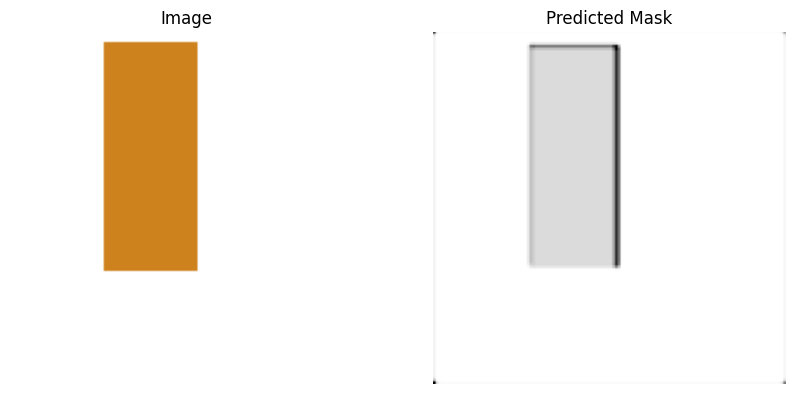

In [25]:
def visualize_segmentation(image, mask, model):  # visualization
    model.eval()
    with torch.no_grad():
        output = model(image.unsqueeze(0))
    predicted_mask = output.squeeze().cpu().numpy()

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image.permute(1, 2, 0))
    plt.title('Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(predicted_mask, cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')
    plt.show()

# Ex:
image, mask = synthetic_dataset[0]
visualize_segmentation(image, mask, model)
